In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.model_evaluation as me
reload(me)

<module 'src.model_evaluation' from '/Users/trungtang/work/assignments/data-science-capstone-project/Kha Huynh/src/model_evaluation.py'>

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
from keras.utils import to_categorical

import tensorflow as tf

# Data Loading

This part is to load all the MIMIC dataset needed to extract train/test data

In [5]:
# df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
# df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
# df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
# df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
# df_labevents = dataLoader.load_labevents(df_demographic)
# # df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

# Dataset Extraction
Based on the results of feature selection in traditional machine learning models, we selected the top 20 features that were confirmed by the feature selection step. To harness the flexibility of LSTM networks for time series data, we experimented with different time steps from 0 to 8 to determine the most predictive data.

In [3]:
hours_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
top_n_features = [20]
dfs_dict = {}

The code below extract data by top n features and time t and save them into the folder. To save time, the files are uploaded and will be loaded for training the model

In [5]:
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/full_data_lstm/t{hour}_top{top_n}_sequence.csv'
    try:
      extracted_df = pd.read_csv(output_filename)
    except:
      extracted_df = dataLoader.create_train_data_sequence_new(df_labevents, df_demographic, df_desc_labitems, hours=hour, feature_no=top_n, output_filename = output_filename)
    extracted_df['CHARTTIME'] = pd.to_datetime(extracted_df['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
    dfs_dict[f'top{top_n}'][f't{hour}'] = extracted_df

# Data Processing
In the MIMIC-III dataset, we primarily focus on laboratory event results presented in a time series format. To utilize the advantage of LSTM networks on timeseries event results, it is needed to determine at which timestep since admission, the patient has all the abnormal signs in laboratory result and is not yet treated. We specifically examine the initial 8 hours following admission to determine the most effective time step for predicting sepsis. This approach aims to train the model using event results before medical treatment is administered.
The extracted data will be divided into three sets: training, validation, and test sets, utilizing stratified splitting to address the imbalance in the target class.

The training set is first imputed using the median for missing values, followed by standardization. The same transformations are then applied to the validation and test sets using the parameters learned from the training set.

In [6]:
top_features = [f'top{i}' for i in top_n_features] 
time_windows = [f't{i}' for i in hours_list]

In [7]:
from sklearn.impute import SimpleImputer

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(full_df, splitted_df):
    x_df = full_df.merge(splitted_df[['SUBJECT_ID', 'HADM_ID']])
    x_df['count'] = x_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_count = x_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_df = x_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_df, x_count, y_df

def impute_norm_data(x_train_df, x_test_df, x_val_df):
    imputer = SimpleImputer(strategy='median', missing_values=np.nan)

    train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
    test_gendernum = x_test_df.GENDER_NUM.values
    val_gendernum = x_val_df.GENDER_NUM.values

    # impute X
    x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
    x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
    x_val = imputer.transform(x_val_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

    # Feature scaling - Standardisation
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train) #scale X
    x_test = scaler.transform(x_test)
    x_val = scaler.transform(x_val)

    x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
    x_test = np.column_stack((x_test, test_gendernum))
    x_val = np.column_stack((x_val, val_gendernum))

    x_train_norm = x_train
    x_test_norm = x_test

    return x_train, x_test, x_val, x_train_norm, x_test_norm

def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels

def data_preparation(x_train, x_train_count, y_train_df, 
                     x_test, x_test_count, y_test_df,
                     x_val, x_val_count, y_val_df):
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)
  val_data, act_val = ts_to_secs(x_val, x_val_count, y_val_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())
  print("[INFO] -- Shape of Validation Sections:")
  print(val_data.bounding_shape())

  return train_data, act_train, test_data, act_test, val_data, act_val

In [8]:
split_df_dict = {}
split_data_dict = {}
split_norm_dict = {}

for top in top_features:
    dfs_list = []
    
    for time in time_windows:
        df_data = dfs_dict[top][time]
        admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

        x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                        admission['IS_SEPSIS'],
                                                        test_size=0.2,
                                                        )

        x_train_df, x_val_df, _, _ = df_split(x_train_df,  # dropping the target column for X values
                                                y_train_df,
                                                test_size=0.15,
                                                )

        x_train_df, x_train_count, y_train_df = create_data_df(df_data, x_train_df)
        x_test_df, x_test_count, y_test_df = create_data_df(df_data, x_test_df)
        x_val_df, x_val_count, y_val_df = create_data_df(df_data, x_val_df)

        # impute missing value and standardized data
        x_train, x_test, x_val, x_train_norm, x_test_norm = impute_norm_data(x_train_df, x_test_df, x_val_df)
        x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(
            x_train, x_train_count, y_train_df, 
            x_test, x_test_count, y_test_df,
            x_val, x_val_count, y_val_df)
        
        # Store split dataframe
        split_df_dict[(top, time)] = {'x_train_df': x_train_df, 'x_test_df': x_test_df, 'x_val_df': x_val_df, 'y_train_df': y_train_df, 'y_test_df': y_test_df, 'y_val_df': y_val_df, 'x_train_norm': x_train_norm, 'x_test_norm': x_test_norm}
        # Store split data
        split_data_dict[(top, time)] = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'x_val': x_val, 'y_val': y_val}

[INFO] -- Shape of Training Sections:
tf.Tensor([23414     1    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([6887    1   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([4133    1   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Training Sections:
tf.Tensor([26783     6    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([7878    6   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([4727    6   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Training Sections:
tf.Tensor([28801     9    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([8471    9   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([5083    8   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Training Sections:
tf.Tensor([30192    11    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([8881   11   24], shape=(3,), dtype=int6

# Model Fitting
The deep learning model used is an LSTM model, with some parameters:
- Evaluation metrics including BinaryAccuracy and AUC
- Optimizer: Adam
- The learning rate schedule used is the exponential learning rate with initial learning rate 0.001, which has been fine-tuned in the "FineTune_learningRate.ipynb" file located under the "Kha Huynh/ModelTraining" folder.
- The model contains two LSTM layers with ReLU activation function, followed by a dense layer with a sigmoid activation function. There are dropout layers in between to prevent overfitting. The model's output includes two probabilities: one for NON-SEPSIS and one for SEPSIS.
- The model is trained for 50 epochs, and early stopping is applied after 10 epochs if there is no improvement in the validation accuracy.

Each model of t 0-8 is trained on training set and evaluated on validation set.

In [43]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

model_hist_dict = {}
models_dict = {}

In [12]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def LSTM_model(x_train):
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

In [ ]:
for top in top_features:
  model_hist_dict[top] = {}
  for time in time_windows:
    print(f"----------------Start model {top}, {time}---------------------")

    x_train = split_data_dict[(top, time)]['x_train']
    y_train = split_data_dict[(top, time)]['y_train']
    x_test = split_data_dict[(top, time)]['x_test']
    y_test = split_data_dict[(top, time)]['y_test']
    x_val = split_data_dict[(top, time)]['x_val']
    y_val = split_data_dict[(top, time)]['y_val']

    model = LSTM_model(x_train)
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)

    checkpointer = ModelCheckpoint(filepath = f'models/LSTM_{top}_{time}_model.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=10, restore_best_weights=True)
    callbacks_list = [lr_scheduler, early_stop, checkpointer]
    
    sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))

    m = model.fit(x_train,y_train,
                  sample_weight=sample_weights,
                  # class_weight=me.get_class_weights(y_train_df),
                  epochs=50, batch_size=64, verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks=callbacks_list)
    model_hist_dict[top][time] = m

The plots below are the accuracy, AUC, and loss of the trained model.

In most cases, the training accuracy stabilizes at approximately 0.8, whereas the validation accuracy displays fluctuations. This could suggest that the model might be overly complex or certain hyperparameters may need optimization. As a result, we have initiated fine-tuning efforts on the model structure in the "Kha Huynh/ModelTraining/Finetune_modelStructure_x" files. However, more trial needs to be applied.

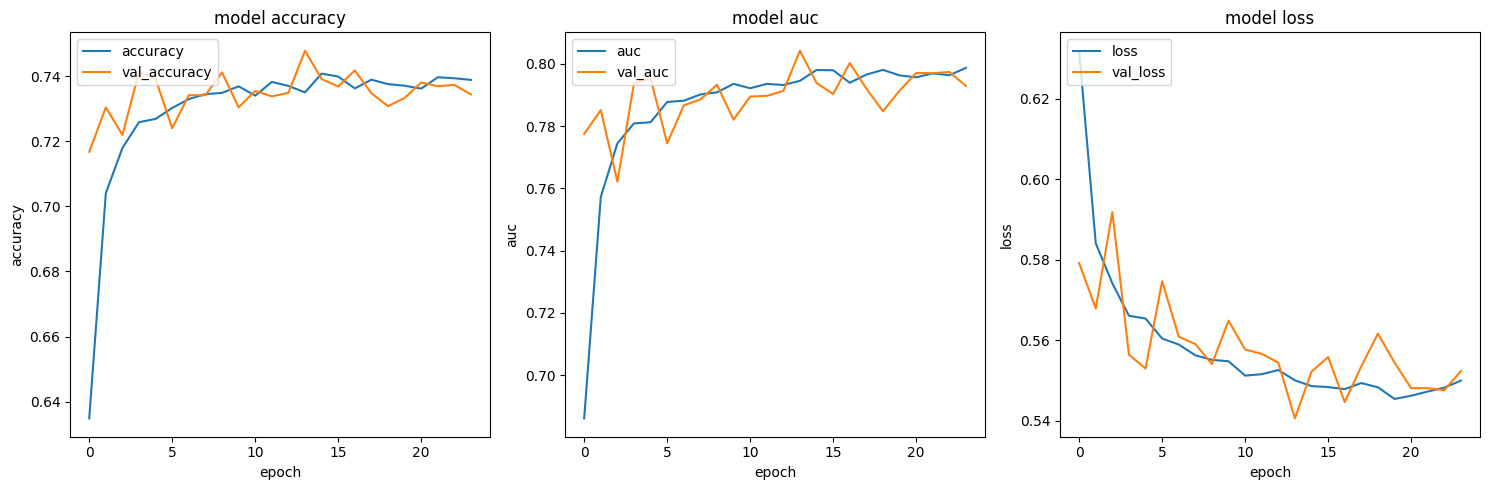

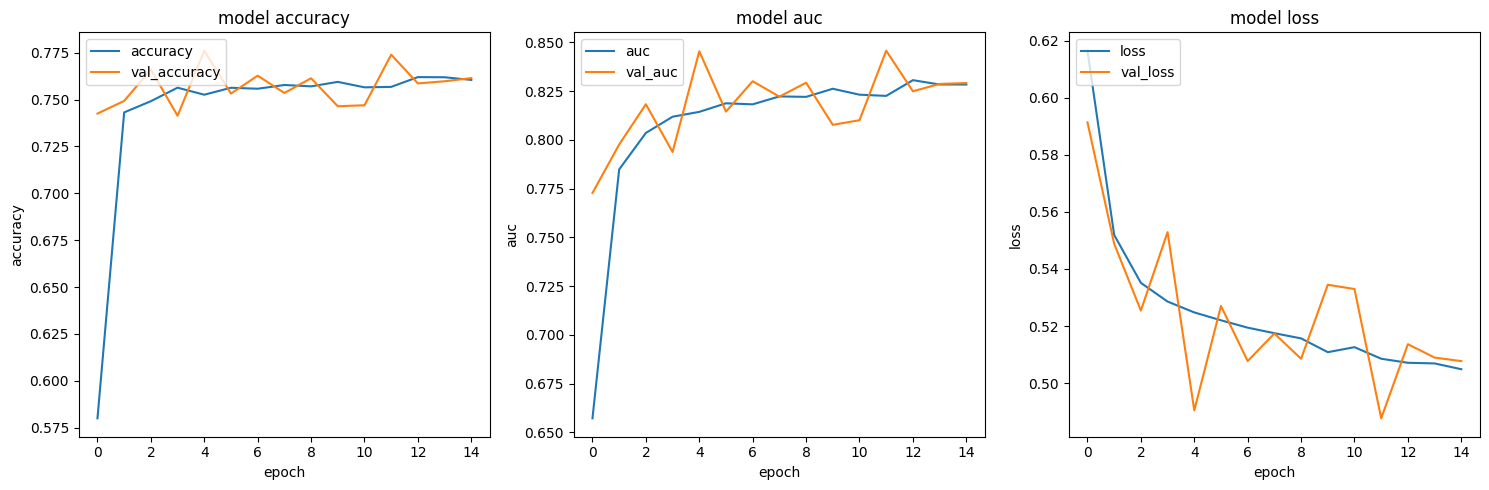

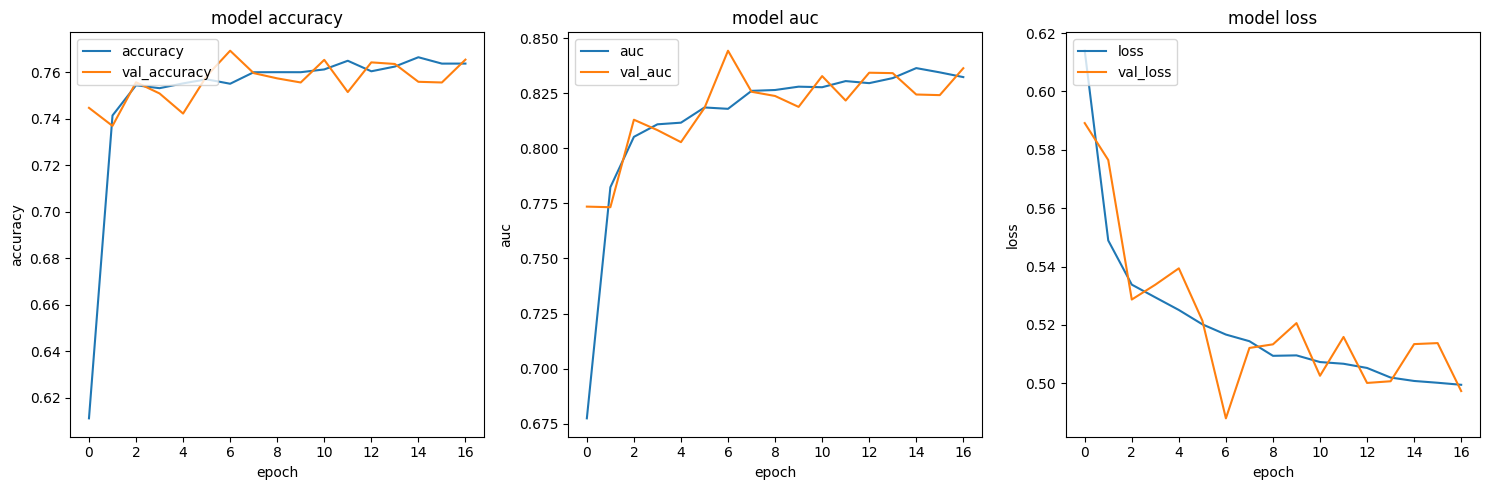

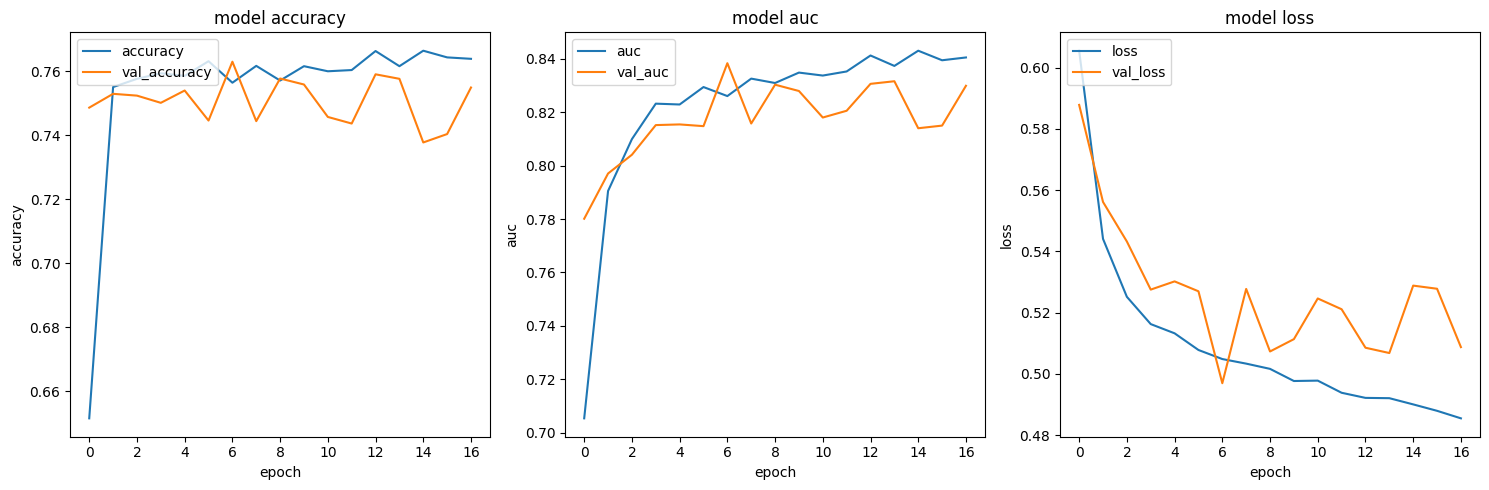

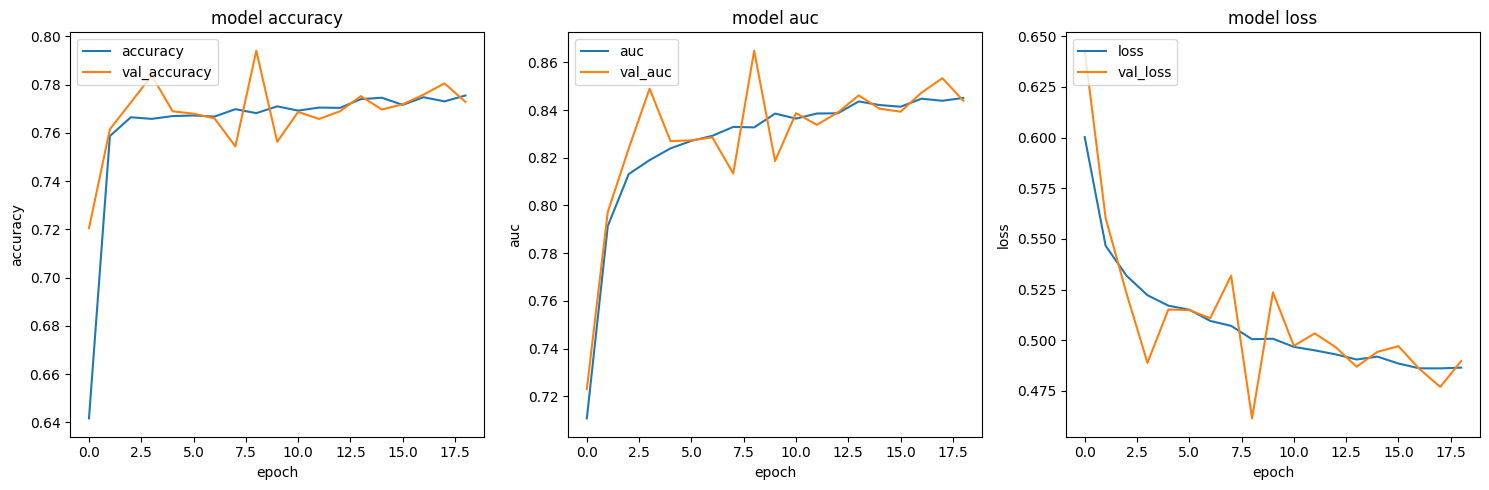

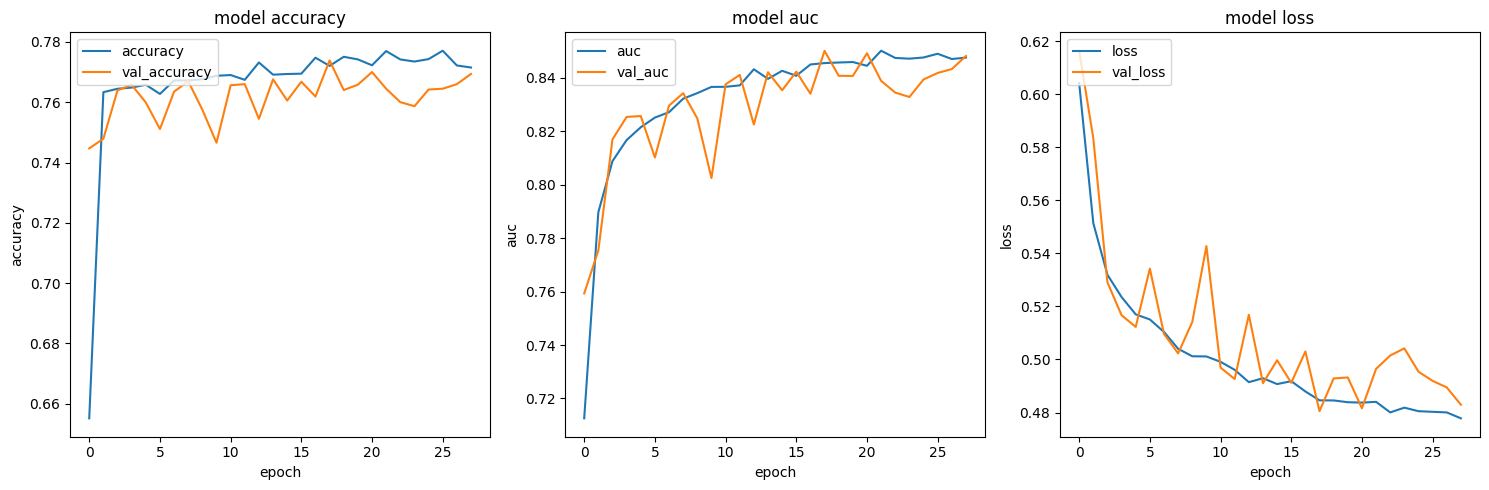

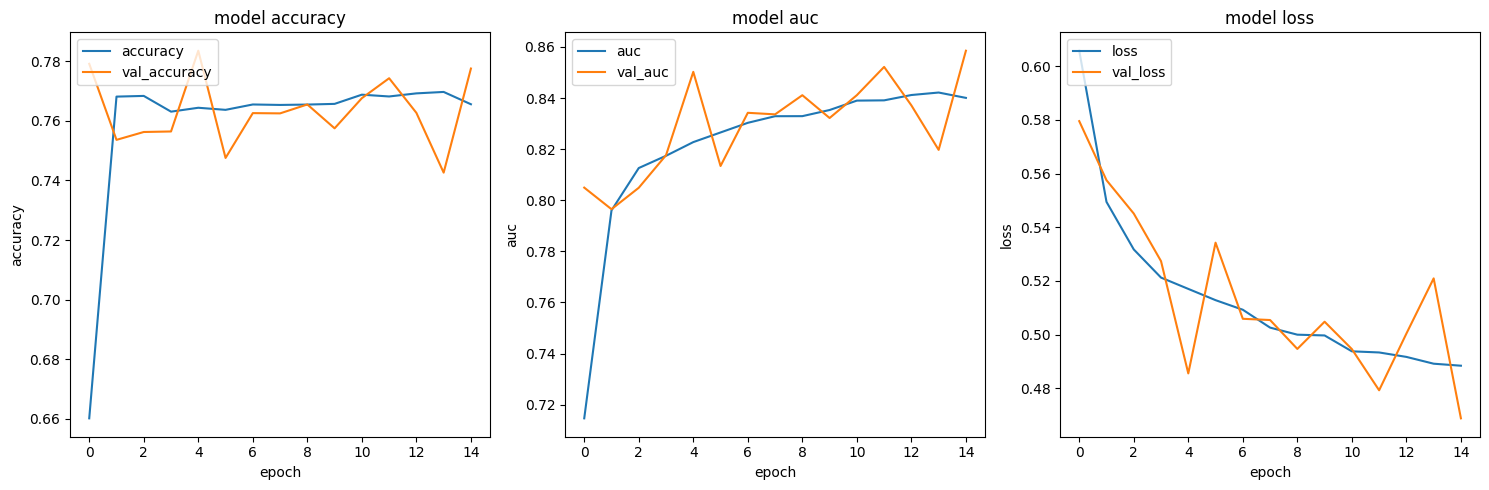

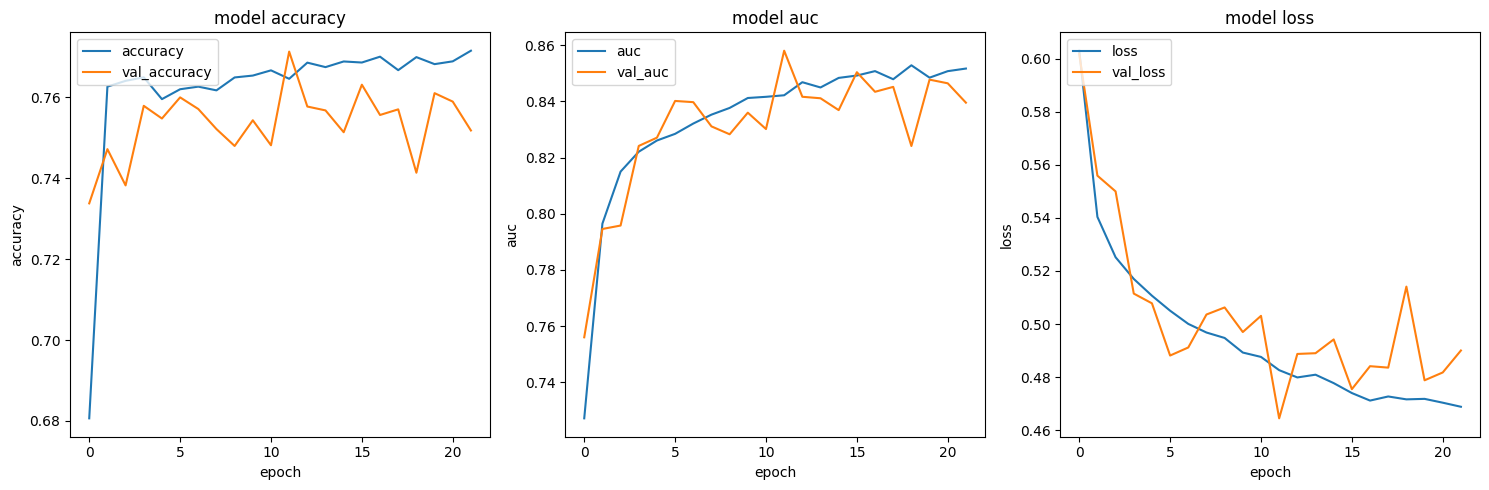

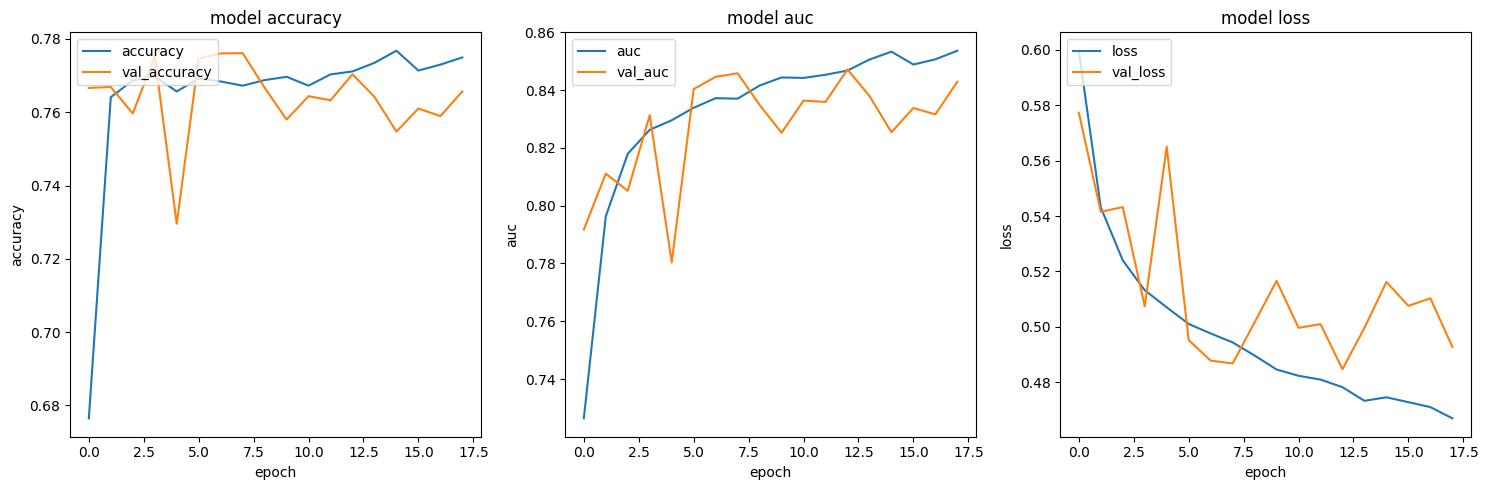

In [20]:
import matplotlib.pyplot as plt

for top in top_features:
  for time in time_windows:
    # Create a figure with two subplots side by side
    fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
    m_hist = model_hist_dict[top][time]
    
    # plt.plot(m.history['loss'])
    plt1.plot(m_hist.history['accuracy'])
    plt1.plot(m_hist.history['val_accuracy'])
    plt1.set_title('model accuracy')
    plt1.set_ylabel('accuracy')
    plt1.set_xlabel('epoch')
    plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

    # plt.plot(m.history['loss'])
    plt2.plot(m_hist.history['auc'])
    plt2.plot(m_hist.history['val_auc'])
    plt2.set_title('model auc')
    plt2.set_ylabel('auc')
    plt2.set_xlabel('epoch')
    plt2.legend(['auc', 'val_auc'], loc='upper left')

    # plt.plot(m.history['loss'])
    plt3.plot(m_hist.history['loss'])
    plt3.plot(m_hist.history['val_loss'])
    plt3.set_title('model loss')
    plt3.set_ylabel('loss')
    plt3.set_xlabel('epoch')
    plt3.legend(['loss', 'val_loss'], loc='upper left')

    plt.tight_layout()
    plt.show()

The following are the ROC curves and performance of the models.

The t8 dominant in AUC, balanced accuracy and F1 Score. Therefore, it will be selected as the best model.

302/302 [==============================] - 1s 3ms/step


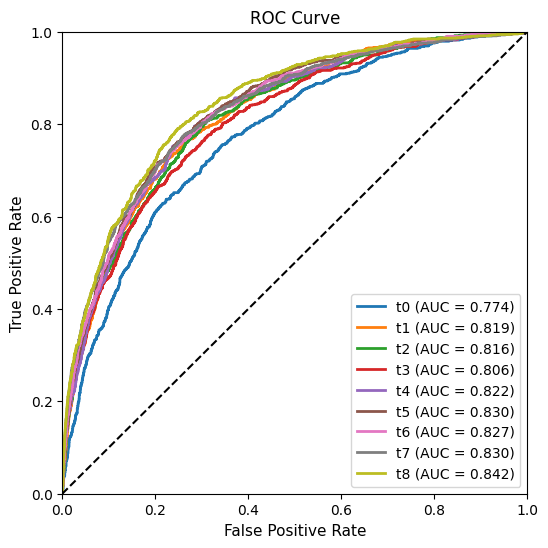

In [9]:
from keras.models import load_model
reload(me)

trained_models = {}
for top in top_features:
  trained_models[top] = {}
  for time in time_windows:  
    model = load_model(f'models/LSTM_{top}_{time}_model.hdf5')
    trained_models[top][time] = model

full_perf, test_perf = me.plot_combined_roc_curves_t(trained_models, split_data_dict, top_features, time_windows)

In [21]:
full_perf

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,AUC
0,t0,0.725,0.703,0.267,0.248,0.694,0.662,0.385,0.361,0.774
1,t1,0.750,0.743,0.299,0.295,0.709,0.698,0.420,0.414,0.819
2,t2,0.755,0.738,0.297,0.279,0.723,0.701,0.421,0.399,0.816
3,t3,0.761,0.726,0.293,0.272,0.740,0.673,0.420,0.387,0.806
4,t4,0.757,0.743,0.307,0.300,0.705,0.676,0.428,0.416,0.822
5,t5,0.771,0.754,0.300,0.281,0.751,0.732,0.429,0.406,0.830
6,t6,0.753,0.753,0.288,0.287,0.717,0.718,0.410,0.410,0.827
7,t7,0.773,0.752,0.299,0.289,0.754,0.711,0.428,0.411,0.830
8,t8,0.769,0.766,0.294,0.291,0.749,0.747,0.423,0.419,0.842


Get the best model's objects

In [10]:
top = 'top20'
time = 't8'
x_train = split_data_dict[(top, time)]['x_train']
y_train = split_data_dict[(top, time)]['y_train']
x_test = split_data_dict[(top, time)]['x_test']
y_test = split_data_dict[(top, time)]['y_test']
model = trained_models[top][time]

x_train_df = split_df_dict[('top20', 't8')]['x_train_df']
x_test_df = split_df_dict[('top20', 't8')]['x_test_df']
x_train_norm = split_df_dict[('top20', 't8')]['x_train_norm']
x_test_norm = split_df_dict[('top20', 't8')]['x_test_norm']

302/302 [==============================] - 1s 3ms/step
***[RESULT]*** ACT  Confusion Matrix


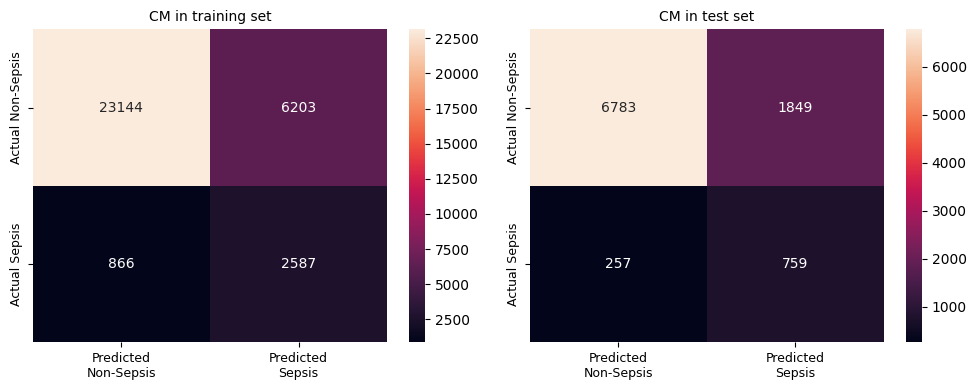

                 Train      Test
Balanced Acc  0.768918  0.766422
Precision     0.294312  0.291028
Recall        0.749204  0.747047
F1-Score      0.422609  0.418874


In [39]:
me.print_results(model, x_train, y_train, x_test, y_test)

  1/302 [..............................] - ETA: 2s302/302 [==============================] - 1s 4ms/step
Average Precision (AP): 0.4400


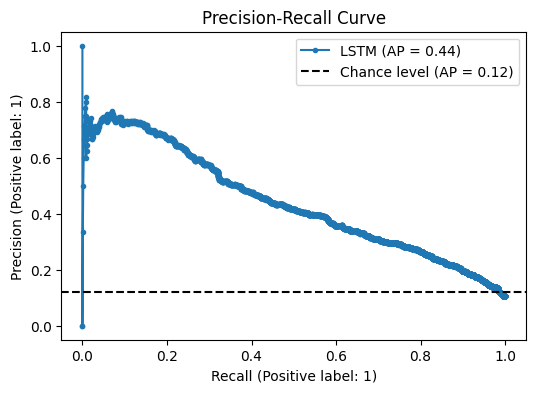

In [28]:
reload(me)
me.plot_precision_recall(model, 'LSTM', x_test, y_test)

# Feature Importance

## TimeShap

In [11]:
f = lambda x: model.predict(x)[:, 1]
raw_model_features = x_train_df.columns
model_features = [f"p_normalize_{x}" for x in np.delete(raw_model_features, [0,1,3,4, 5, -1])]
model_features.append(f"p_normalize_{raw_model_features[3]}")

In [12]:
d_train_normalized = pd.concat([x_train_df, pd.DataFrame(x_train_norm, columns=model_features)], axis=1)
d_test_normalized = pd.concat([x_test_df, pd.DataFrame(x_test_norm, columns=model_features)], axis=1)

In [13]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(d_train_normalized, numerical_feats=model_features, categorical_feats=[])
average_event

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,p_normalize_AGE,p_normalize_ITEMID_50813,p_normalize_ITEMID_50821,p_normalize_ITEMID_50862,p_normalize_ITEMID_50882,p_normalize_ITEMID_50885,p_normalize_ITEMID_50893,p_normalize_ITEMID_50902,p_normalize_ITEMID_50912,p_normalize_ITEMID_50931,...,p_normalize_ITEMID_51237,p_normalize_ITEMID_51244,p_normalize_ITEMID_51256,p_normalize_ITEMID_51265,p_normalize_ITEMID_51274,p_normalize_ITEMID_51277,p_normalize_ITEMID_51279,p_normalize_ITEMID_51301,p_normalize_SOFA,p_normalize_GENDER_NUM
0,0.203511,-0.010197,-0.100406,0.008998,0.025074,-0.030673,0.009051,0.005366,-0.014891,-0.159366,...,0.016822,-0.07763,0.08821,-0.086321,-0.035212,0.005618,0.019331,-0.041434,-0.058137,0.0


### Local explanations

In [14]:
ids_for_test = [100074, 100223, 100047, 100165] # first 2 hadm_id are sepsis case, last 2 are non-sepsis
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'].isin(ids_for_test)]
labels = d_test_normalized[d_test_normalized.HADM_ID.isin(ids_for_test)].drop_duplicates(['HADM_ID'])[['HADM_ID', 'IS_SEPSIS']]

# select model features only
# pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = [np.expand_dims(pos_x_pd[pos_x_pd.HADM_ID==x][model_features].to_numpy().copy(), axis=0) for x in ids_for_test]

In [15]:
_, df_desc_labitems,_ = dataLoader.load_descriptions()

In [16]:
plot_feats_1 = {model_features[0]:model_features[0][12:]}
plot_feats_2 = {x:x[12:] for x in model_features[-2:]}
plot_feats_3 = {x: df_desc_labitems[df_desc_labitems.ITEMID == int(x[19:])].LABEL.values[0] for x in model_features[1:-2]}
plot_feats = {**plot_feats_1, **plot_feats_3, **plot_feats_2}

In [22]:
from timeshap.explainer import local_report, local_pruning, local_feat
from timeshap.plot import plot_feat_barplot, plot_global_feat, feature_level
import altair  as alt
sequence_id_feat = 'HADM_ID'

def plot_local_features(ids_for_test, pos_x_data, labels):
  objects = len(ids_for_test)
  plots = []
  for pos_id in list(range(0,objects)):
    hadm_id = ids_for_test[pos_id]
    pos_x = pos_x_data[pos_id]
    label = 'SEPSIS' if labels[labels.HADM_ID == hadm_id]['IS_SEPSIS'].values==1 else 'NON-SEPSIS'
    pruning_dict = {'tol': 0.025,}
    coal_plot_data, coal_prun_idx = local_pruning(f, pos_x, pruning_dict, average_event, hadm_id, sequence_id_feat, False)
    # coal_prun_idx is in negative terms
    pruning_idx = pos_x.shape[1] + coal_prun_idx

    feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
    feature_data = local_feat(f, pos_x, feature_dict, hadm_id, sequence_id_feat, average_event, pruning_idx)
    feat_plot_0 = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
    feat_plot_0 = feat_plot_0.properties(width=500, height = {'step': 15}, title=f'HADM_ID: {hadm_id}, {label}')
    feat_plot_0 = feat_plot_0.encode(
        x=alt.X('Shapley Value', type='quantitative', scale=alt.Scale(domain=[-0.5, 0.5]))
    )
    plots.append(feat_plot_0)
  return plots

In [23]:
feat_plots = plot_local_features(ids_for_test, pos_x_data, labels)

1000/1000 [==============================] - 2s 2ms/step


In [24]:
(feat_plots[0] | feat_plots[1]) & (feat_plots[2] | feat_plots[3])

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.VConcatChart(...)

### All local plots

In [25]:
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'] == ids_for_test[1]]

# select model features only
pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = np.expand_dims(pos_x_data.to_numpy().copy(), axis=0)

In [26]:
from timeshap.explainer import local_report

pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 32000}
feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f, pos_x_data, pruning_dict, event_dict, feature_dict, cell_dict=cell_dict, entity_uuid=ids_for_test, entity_col='HADM_ID', baseline=average_event)

Assuming all features are model features
16/16 [==============================] - 0s 2ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

## Global Explanations

In [27]:
a = d_test_normalized[d_test_normalized.IS_SEPSIS==1].groupby('HADM_ID')['HADM_ID'].count().reset_index(name='COUNT')

In [28]:
time_feat = 'CHARTTIME'

a = d_test_normalized[d_test_normalized.IS_SEPSIS==1].groupby('HADM_ID')['HADM_ID'].count().reset_index(name='COUNT')
# a = a[a.COUNT>1].head(50)

pos_dataset = d_test_normalized[d_test_normalized['HADM_ID'].isin(a.HADM_ID)]
schema = list(pos_dataset.columns)

In [40]:
from timeshap.explainer import global_report, feat_explain_all

# pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
# event_dict = {'path': 'outputs/event_all_tf.csv', 'rs': 42, 'nsamples': 32000}
# feature_dict = {'path': 'outputs/feature_all_tf.csv', 'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats,}

pruning_dict = {'tol': [0.00000125], 'path': 'outputs/prun_all_tf.csv'}
event_dict = {'rs': 42, 'nsamples': 1000, 'path': 'outputs/event_all_tf.csv'}
feature_dict = {'rs': 42, 'nsamples': 1000, 'feature_names': model_features, 'plot_features': plot_feats, 'path': 'outputs/feature_all_tf.csv'}
prun_stats, global_plot = global_report(f, pos_dataset, pruning_dict, event_dict, feature_dict, average_event, model_features, schema, sequence_id_feat, time_feat, )

Calculating pruning algorithm
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step
Calculating event data
1/1 [==============================] - 0s 16ms/step


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step
Calculating feat data
32/32 [==============================] - 0s 468us/step


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 877us/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step
Calculating pruning indexes


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [42]:
alt.data_transformers.enable("default",max_rows=30000)
global_plot

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.VConcatChart(...)

In [27]:
prun_stats

,Tolerance,Mean,Std
0,0.000001,3.712598,2.234543
1,No Pruning,3.712598,2.234543
